# consistency of self calls
We are trying to see how reliably self echoes are heard and how consistent they are in the information they provide as oppposed to information coming from other direct calls/ echeos from their direct calls

Let us first load the data. 

In [22]:
import sys
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools
os.chdir("/home/adityamoger/Documents/GitHub/dynamic_model_of_cocktail_party_nightmare/")

sys.path.append("./exploratory_analysis/")
sys.path.append("./dynamic_model/")
from snr_implementation import given_sound_objects_return_detected_sounds


from read_simulation_output import read_data_per_simulation_per_bat
from snr_implementation import given_sound_objects_return_detected_sounds
from supporting_files.utilities import make_dir

plt.style.use("dark_background")

In [23]:
NUM_BATS = 30
TEMPORAL_MASKING_DIR = "./exploratory_analysis/temporal_masking_fn.csv"
DIRECTORY = f"/media/adityamoger/T7 Shield/consistency_of_calls/DATA_effect_of_group_size/{NUM_BATS}/iteration_number_3/"
DIRECTORY_STORE_PLOTS = "./exploratory_analysis/plots/"

INCLUDE_DIRECT_SOUNDS_ARR = [True]
FOCAL_BATS = [1, 7, 17]
AZIMUTH_THRESHOLDS = [np.pi / 6, np.pi/2, np.pi]

In [24]:
#store extracted data into a dict
# key needs to be some structure such that the parameters for that can be extracted. maybe ill just make it ordered
def make_ordered_lists_of_params(array_of_parameter_lists):
    product_of_lists = list(itertools.product(*array_of_parameter_lists))
    return product_of_lists

list_of_parameters = [FOCAL_BATS, INCLUDE_DIRECT_SOUNDS_ARR, AZIMUTH_THRESHOLDS]
ordered_list_of_parameters = make_ordered_lists_of_params(list_of_parameters)
labels_of_parameters = ["focal_bat", "include_direct_sounds", "azimuth_thresholds"]

In [25]:
dictionary_to_store_all_sounds = {}
dictionary_to_store_heard_sounds = {}
#keys of dictionary will be  the ordered param lists

for param in ordered_list_of_parameters:
    FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
    track_unique_reflections = []
    sounds_to_plot = []
    times_of_sounds_to_plot = []
    delta_t = []
    OUTPUT_DIR = DIRECTORY + f"/{FOCAL_BAT}/"
    received_sounds_sorted_by_time = read_data_per_simulation_per_bat(
        OUTPUT_DIR, "received"
    )
    if len(received_sounds_sorted_by_time)==0:
        raise ValueError("empty dir")
    
    
    cm = plt.get_cmap("gist_rainbow")


    nan_matrix = (
        np.zeros(
            shape=(len(received_sounds_sorted_by_time), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    list_of_heard_sounds = []
    for i, frame in enumerate(received_sounds_sorted_by_time):
        heard_sounds = given_sound_objects_return_detected_sounds(
            sound_objects=frame,
            time_threshold_post_call=0.035,
            angle_threshold=AZIMUTH,
            dir_of_temporal_masking_fn_file=TEMPORAL_MASKING_DIR,
            minimum_sound_detection_fraction=0.75,
            focal_bat=FOCAL_BAT,
            include_direct_sounds=INCLUDE_DIRECT_SOUNDS,
        )
        list_of_heard_sounds.append(heard_sounds)
    dictionary_to_store_heard_sounds[param] = list_of_heard_sounds
    dictionary_to_store_all_sounds[param] = received_sounds_sorted_by_time
    print(param)


lets plot consistency of self calls. 
the labels are sorted by dictionary ordering. 

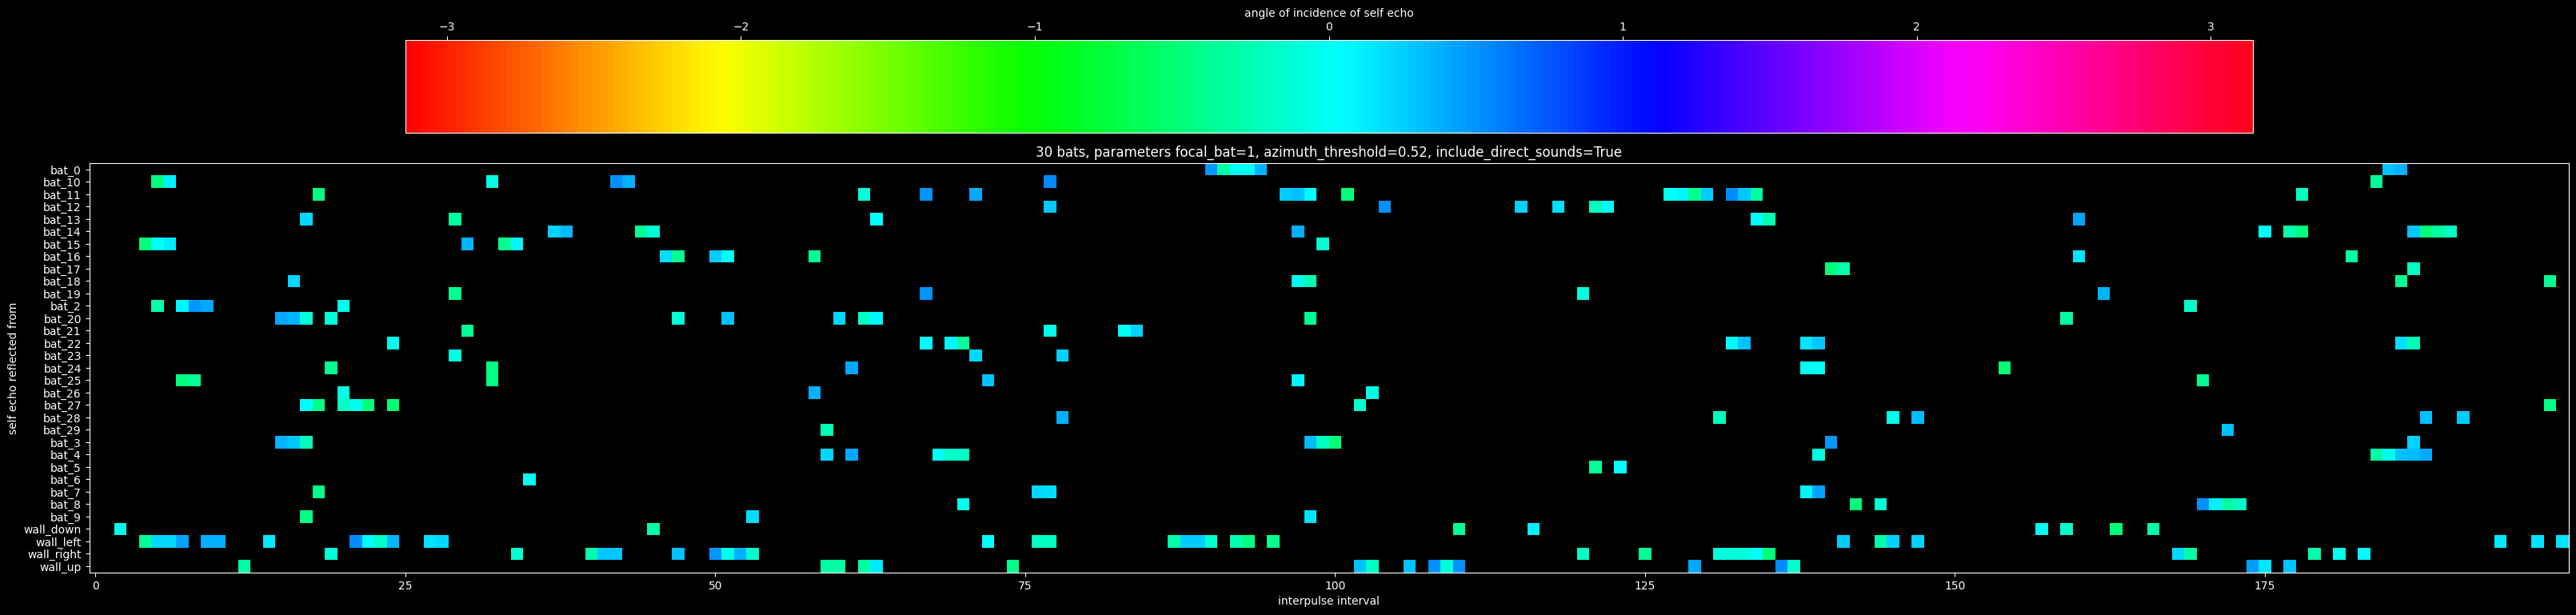

<Figure size 640x480 with 0 Axes>

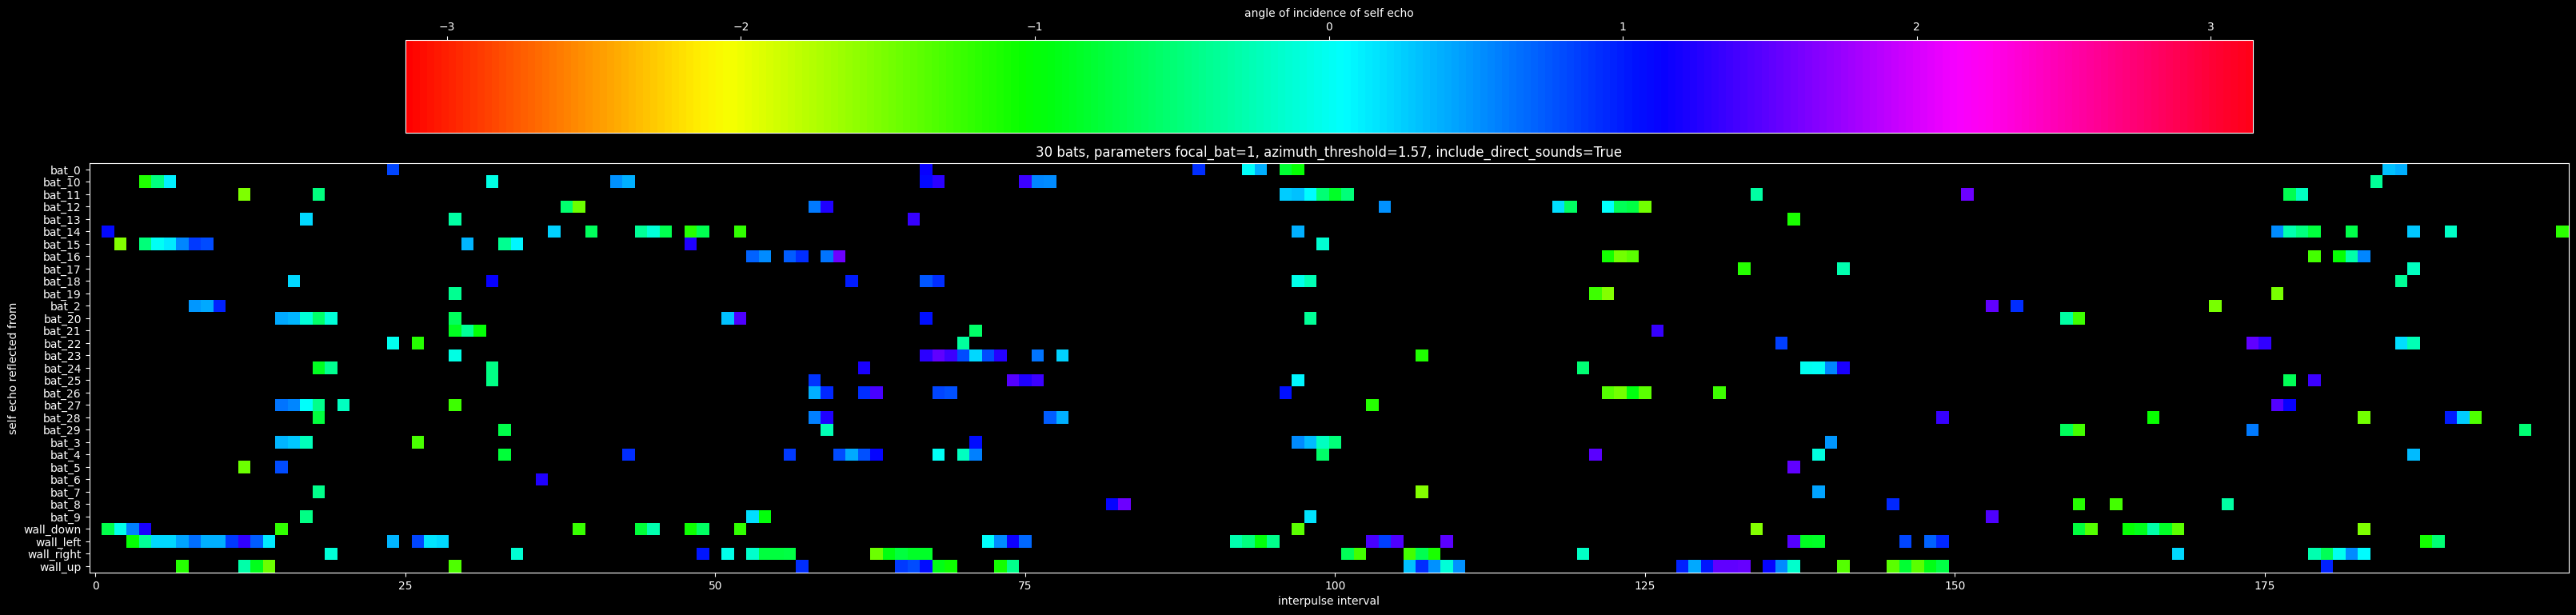

<Figure size 640x480 with 0 Axes>

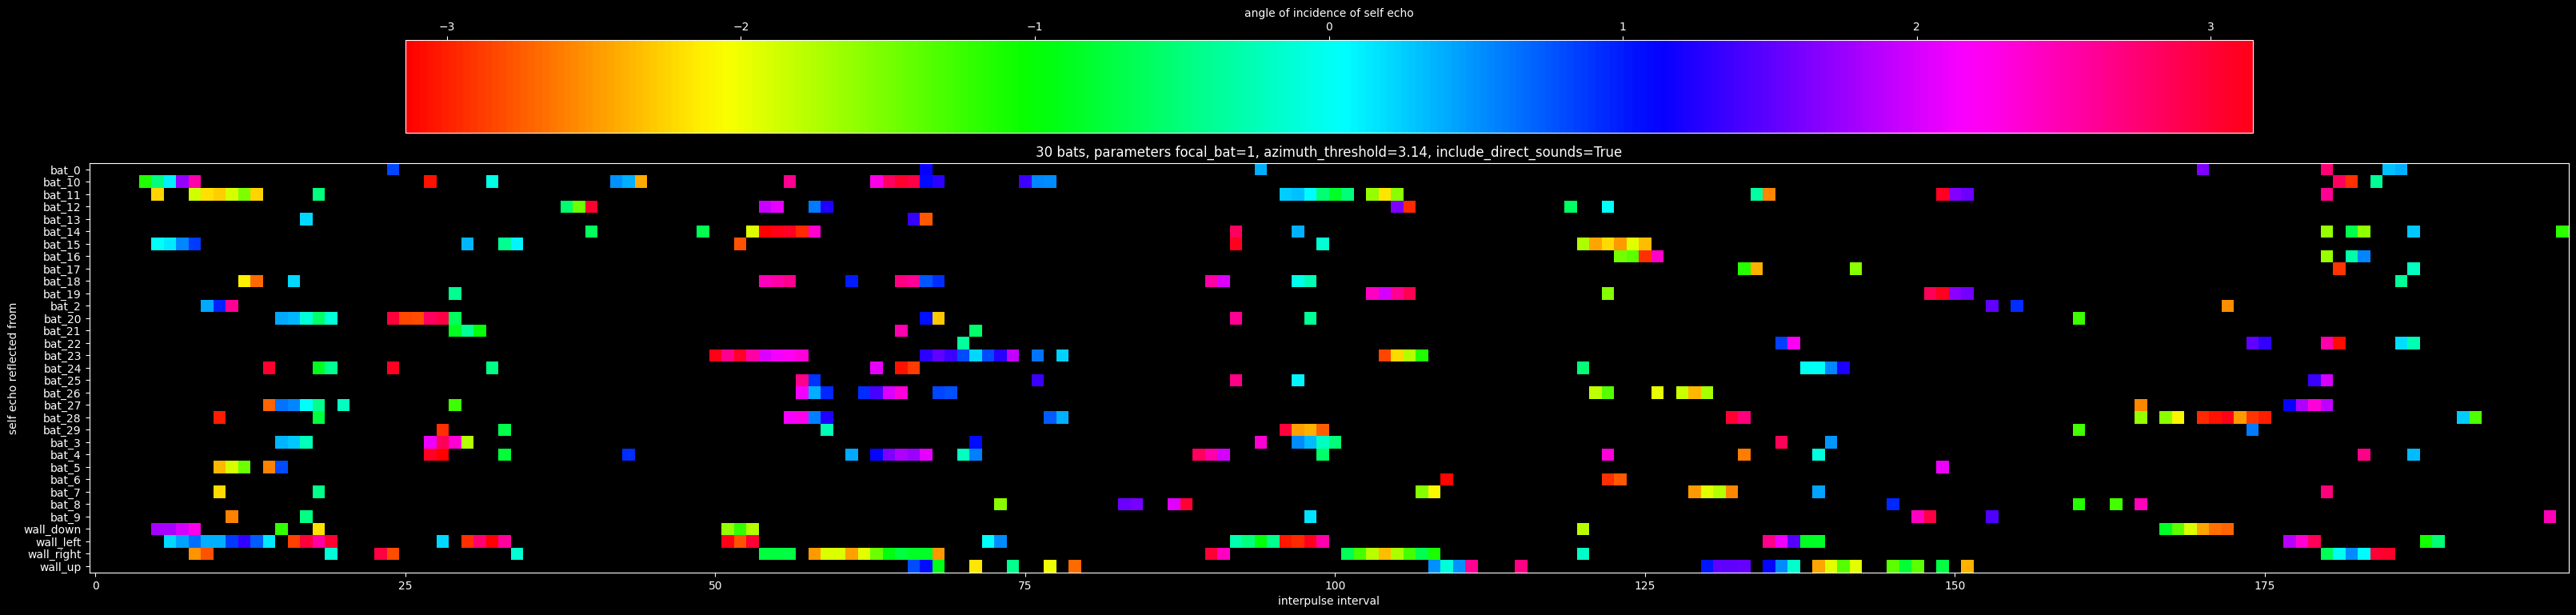

<Figure size 640x480 with 0 Axes>

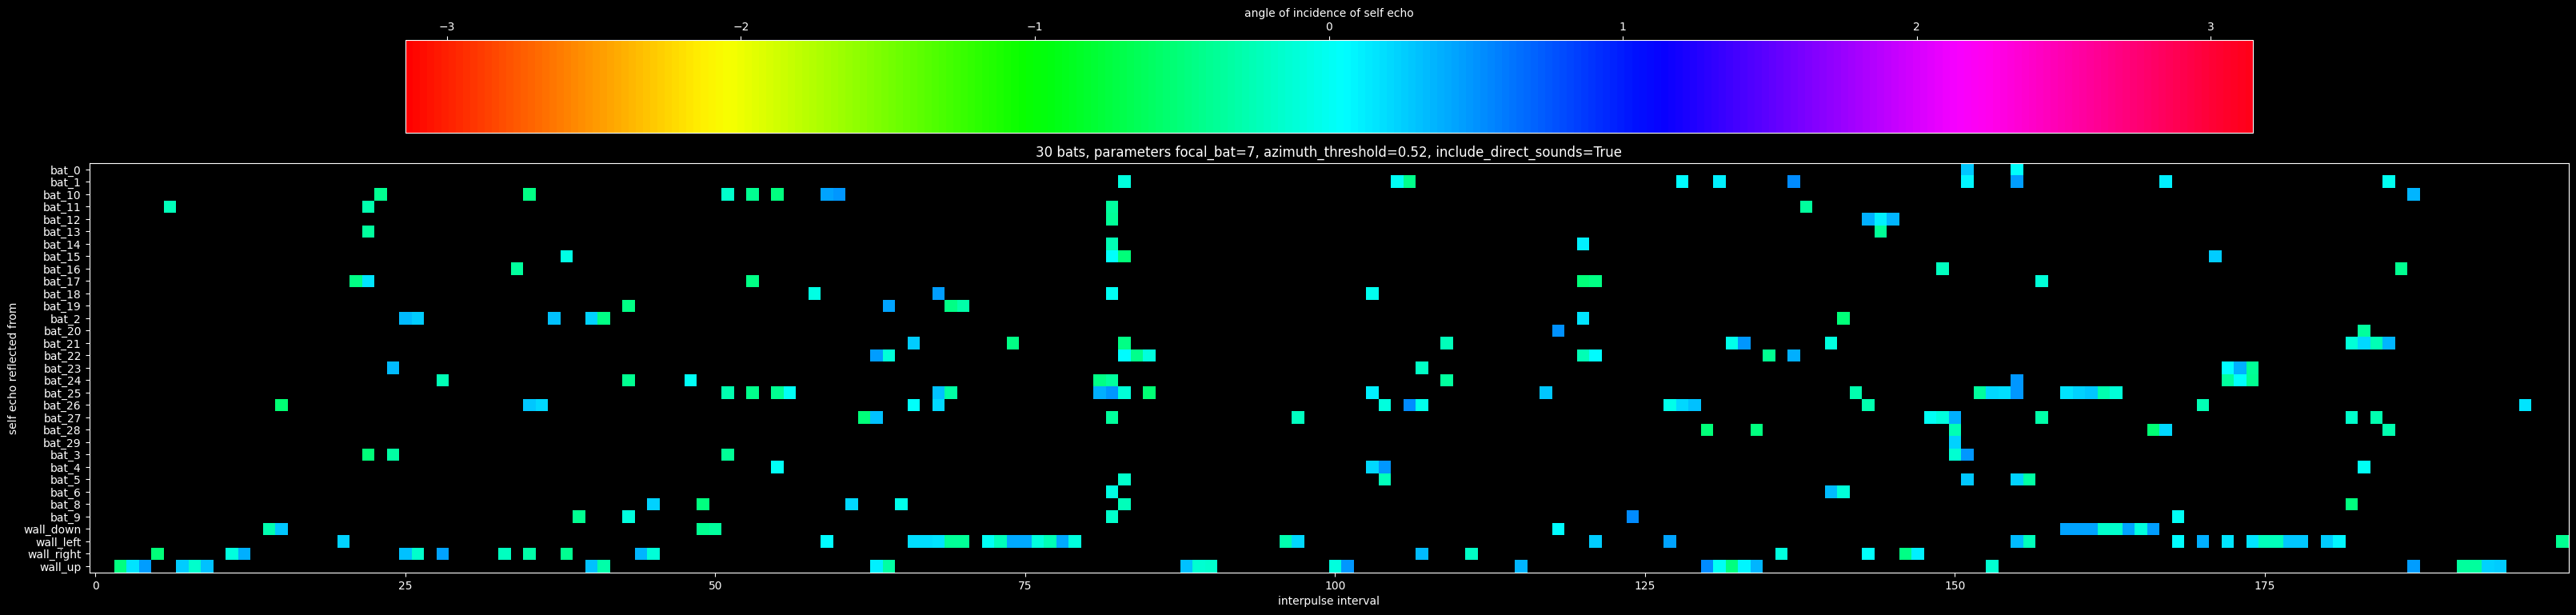

<Figure size 640x480 with 0 Axes>

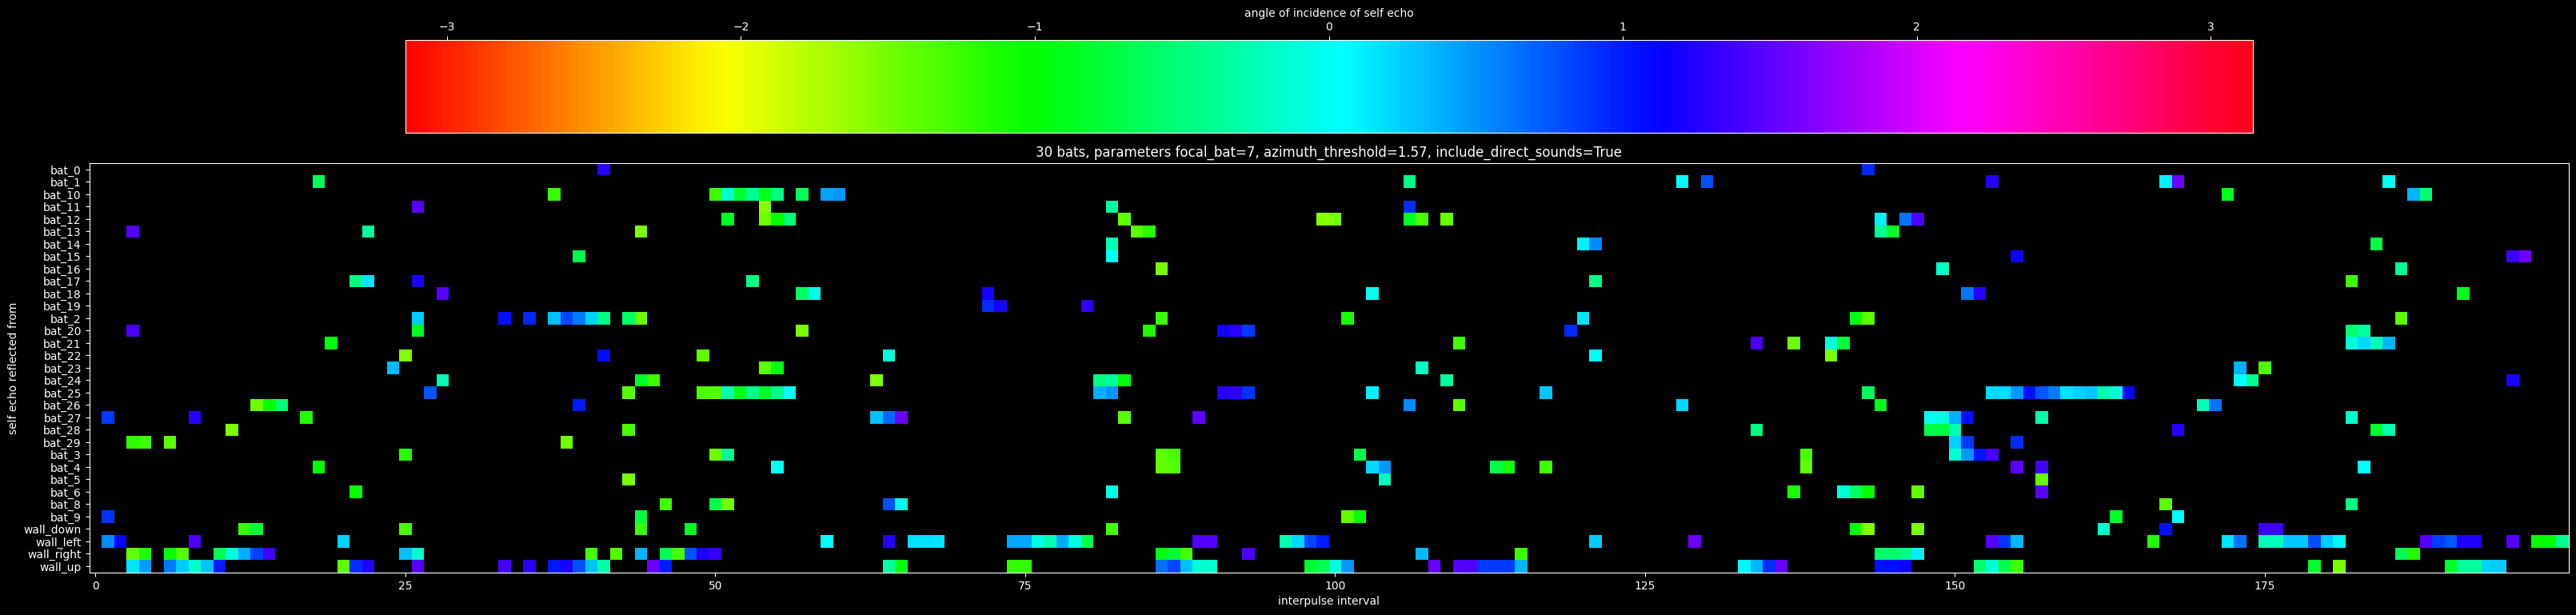

<Figure size 640x480 with 0 Axes>

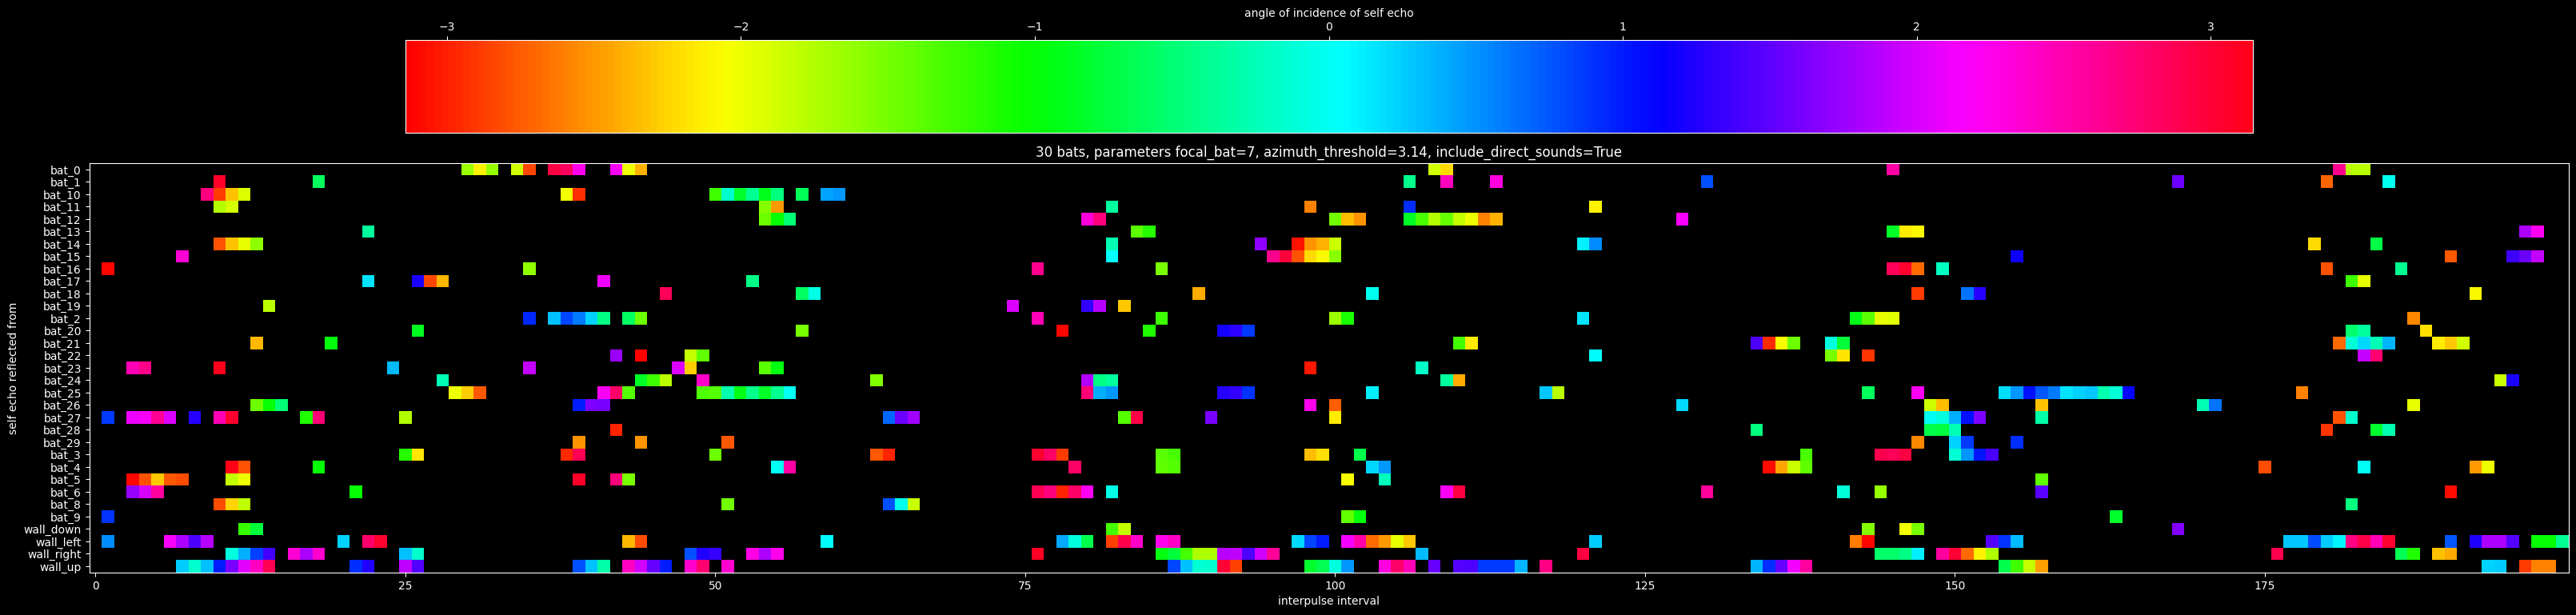

<Figure size 640x480 with 0 Axes>

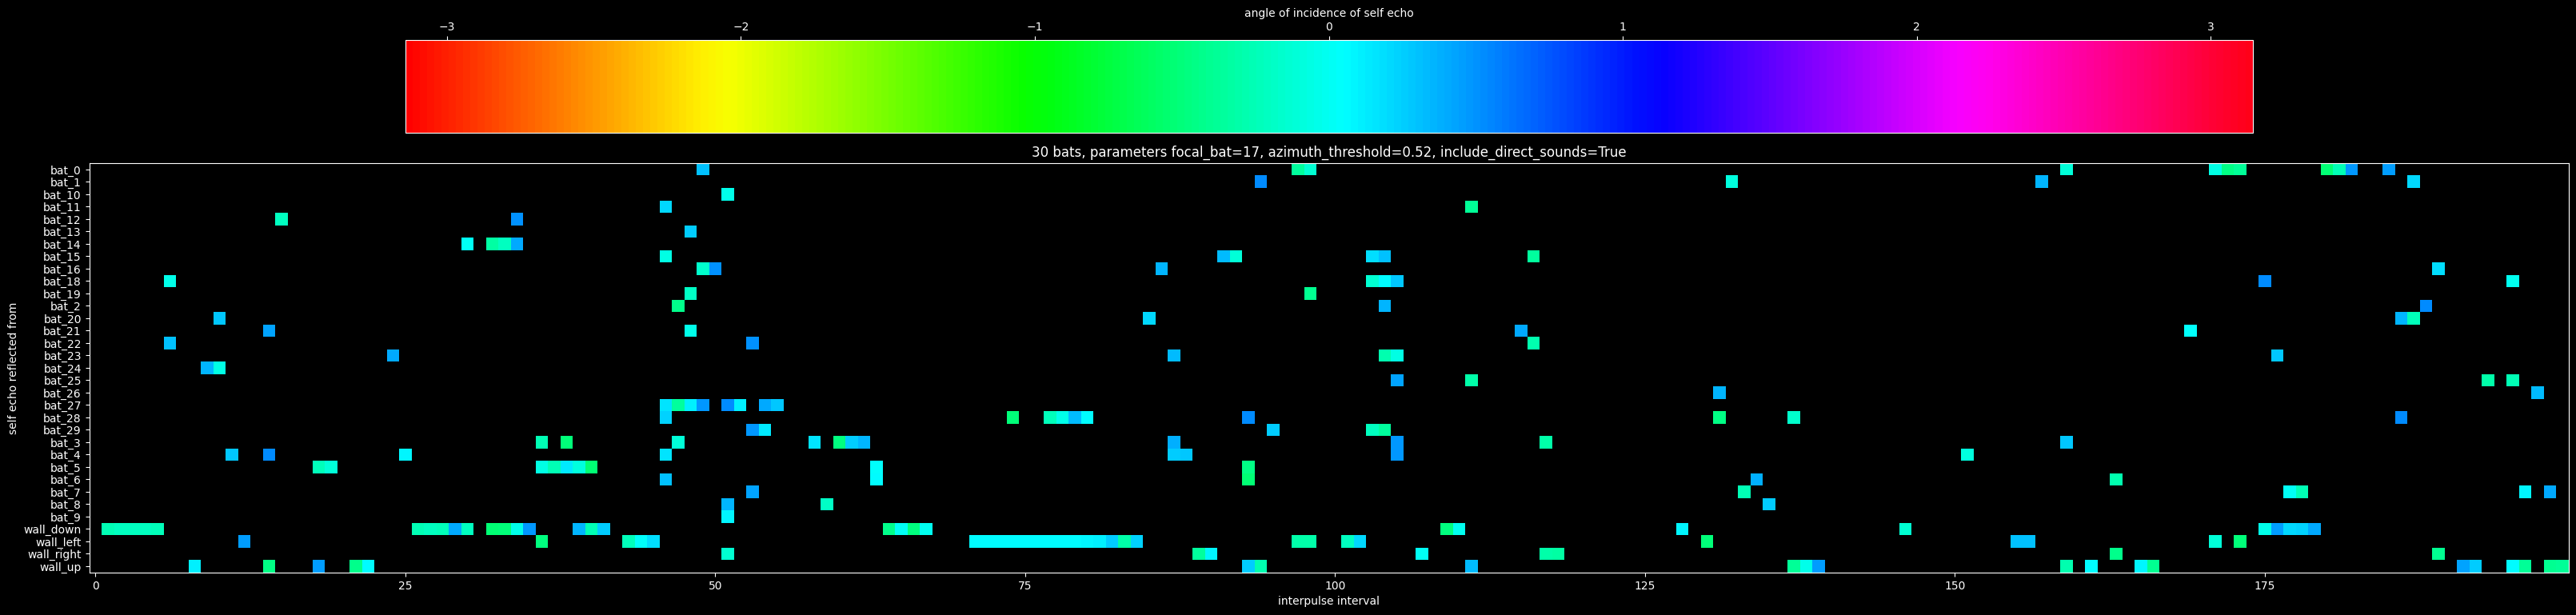

<Figure size 640x480 with 0 Axes>

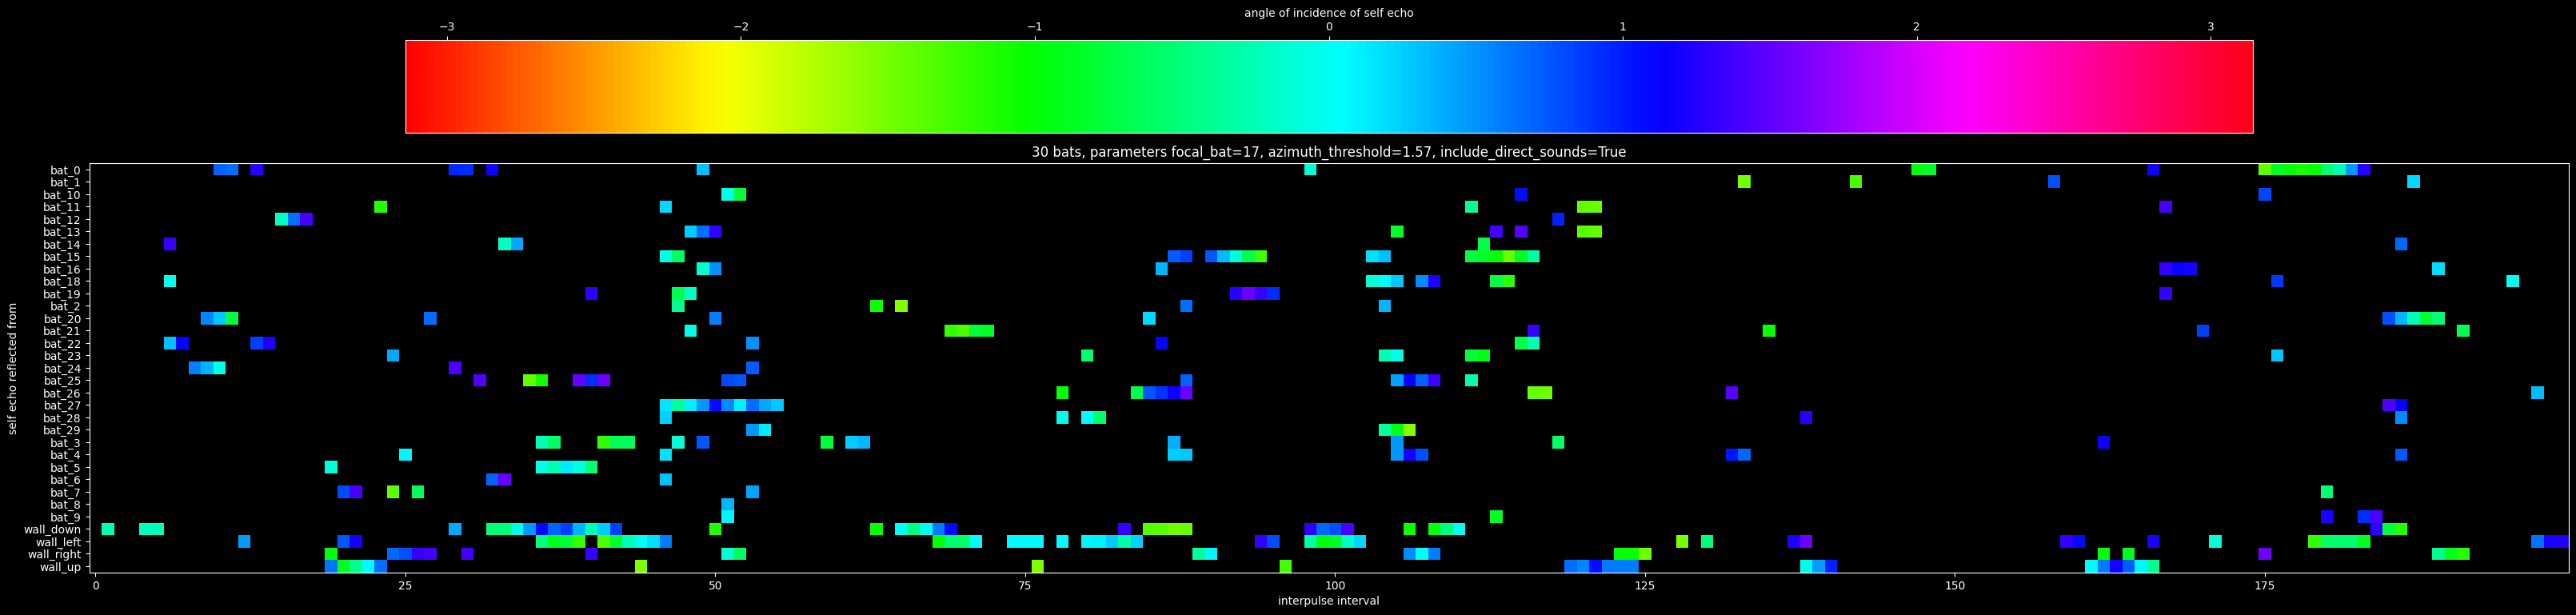

<Figure size 640x480 with 0 Axes>

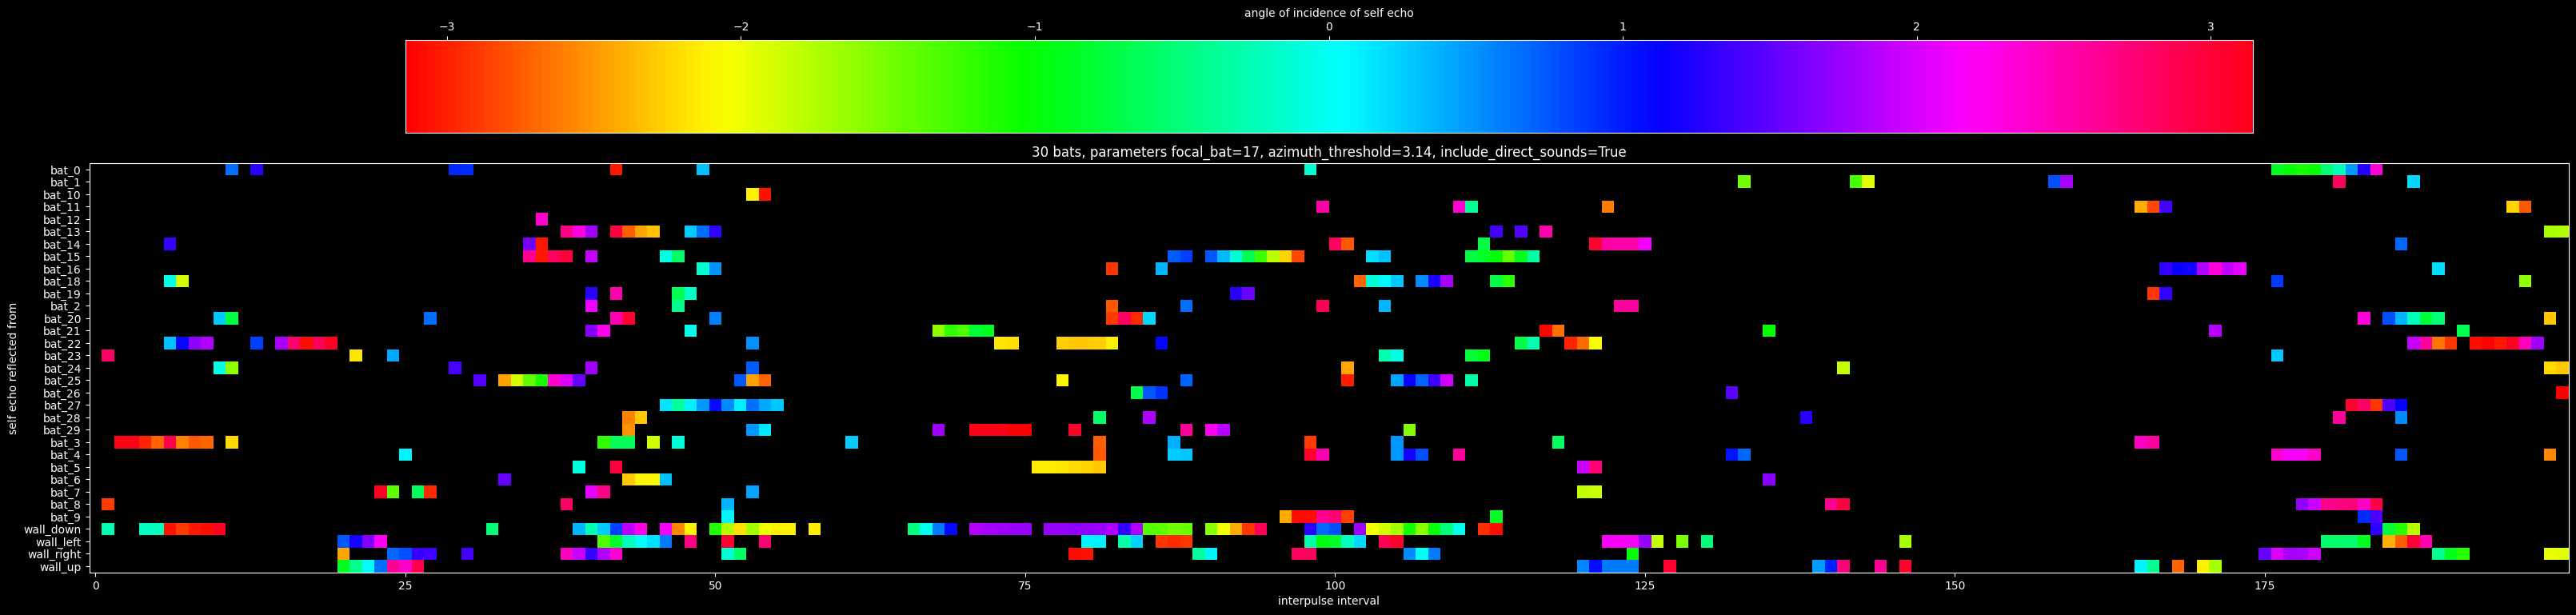

<Figure size 640x480 with 0 Axes>

In [26]:
%matplotlib inline
for param in ordered_list_of_parameters:
    FOCAL_BAT, INCLUDE_DIRECT_SOUNDS, AZIMUTH  = param
    track_unique_reflections = []
    sounds_to_plot = []
    times_of_sounds_to_plot = []
    delta_t = []

    heard_sounds_array = dictionary_to_store_heard_sounds[param]
    
    nan_matrix = (
        np.zeros(
            shape=(len(heard_sounds_array), NUM_BATS - 1 + 4)
        )
        * np.nan
    )
    
    for i, frame_heard_sounds in enumerate(heard_sounds_array):
        
        for sound_object in frame_heard_sounds:

            time = (
                np.array(sound_object["occurance_times"])[0]
                - sound_object["bat_last_call_time"]
                + i * 0.04
            )
            theta = sound_object["bat_direction"].angle_between(
                sound_object["incident_direction"]
            )

            if sound_object["emitter_id"] == FOCAL_BAT:
                reflected_from = sound_object["reflected_from"]

                if reflected_from not in track_unique_reflections:
                    track_unique_reflections.append(reflected_from)
                    times_of_sounds_to_plot.append([])
                    sounds_to_plot.append([])
                    delta_t.append([])
                index = track_unique_reflections.index(reflected_from)
                sounds_to_plot[index].append(theta)
                times_of_sounds_to_plot[index].append(time)
                delta_t[index].append(
                    np.array(sound_object["occurance_times"])[0]
                    - sound_object["bat_last_call_time"]
                )
                # print(theta)
                nan_matrix[i, index] = theta
                
    nan_matrix = nan_matrix[:, ~np.isnan(nan_matrix).all(0)]
    nan_matrix = nan_matrix.T
    
    sorting_indices = np.argsort(track_unique_reflections)
    nan_matrix = nan_matrix[sorting_indices]
    track_unique_reflections = np.array(track_unique_reflections)[sorting_indices]
    
    plt.figure(figsize=(40, 10))
    plt.imshow(nan_matrix, cmap=mpl.colormaps["hsv"])
    plt.colorbar(
        location="top",
        label="angle of incidence of self echo",
    )
    plt.ylabel("self echo reflected from")
    plt.xlabel("interpulse interval")

    plt.yticks(
        labels=track_unique_reflections, ticks=np.arange(0, nan_matrix.shape[0])
    )
    plt.title(f"{NUM_BATS} bats, parameters focal_bat={FOCAL_BAT}, azimuth_threshold={np.round(AZIMUTH,2)}, include_direct_sounds={INCLUDE_DIRECT_SOUNDS}")
    plt.clim(-np.pi, np.pi)
    plt.show()
    plt.clf()